# **AI-FINANCE PROJECT**

## **Project Scope**
* Objective: Use NLP-based sentiment analysis on financial news to improve FPT stock price prediction, along with technical analysis.
* AI Techniques Used: Text classification, entity recognition, and sentiment analysios using BERT and LSTM.
* Key output: A model that correlates financial sentiment with FPT price movements.
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import data file
df = pd.read_csv("FPT Corp Stock Price History.csv")

# Display a few rows of the dataset
print(df.head())

         Date      Price       Open       High        Low   Vol. Change %
0  12/31/2024  152,500.0  150,700.0  153,900.0  150,300.0  3.60M    1.33%
1  12/30/2024  150,500.0  149,400.0  150,800.0  148,500.0  1.98M    0.60%
2  12/27/2024  149,600.0  149,500.0  149,900.0  148,700.0  2.56M   -0.13%
3  12/26/2024  149,800.0  151,000.0  151,400.0  149,100.0  2.23M   -0.66%
4  12/25/2024  150,800.0  150,600.0  151,200.0  150,400.0  2.51M    0.27%


In [3]:
# Check format (types) of each feature
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      998 non-null    object
 1   Price     998 non-null    object
 2   Open      998 non-null    object
 3   High      998 non-null    object
 4   Low       998 non-null    object
 5   Vol.      998 non-null    object
 6   Change %  998 non-null    object
dtypes: object(7)
memory usage: 54.7+ KB
None


Features are not in their correct format (e.g., datatime, float). They need to be converted into their appropriate format for later analysis.

In [4]:
# Convert "Date" to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Convert numerical values to float
num_cols = ["Price", "Open", "High", "Low"]
df[num_cols] = df[num_cols].replace(",", "", regex = True).astype(float)

# Convert "Change %" into decimals
df["Change %"] = (df["Change %"].replace("%", "", regex = True).astype(float))/100

# Re-check data types after conversions
print(df.head())

        Date     Price      Open      High       Low   Vol.  Change %
0 2024-12-31  152500.0  150700.0  153900.0  150300.0  3.60M    0.0133
1 2024-12-30  150500.0  149400.0  150800.0  148500.0  1.98M    0.0060
2 2024-12-27  149600.0  149500.0  149900.0  148700.0  2.56M   -0.0013
3 2024-12-26  149800.0  151000.0  151400.0  149100.0  2.23M   -0.0066
4 2024-12-25  150800.0  150600.0  151200.0  150400.0  2.51M    0.0027


# 1. Exploratory Data Analysis

## A. Missing Values

In [5]:
# Check Missing values
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

## B. Outliers

There is no missing value in the dataset

In [6]:
# Define a function to detect outliers, using IQR
def detect_outliers(data, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

# Detect outliers, checking numercial columns
num_col = df.select_dtypes("float64").columns
for cols in num_col:
    outliers = detect_outliers(df, cols)
    print(f"Outliers in {cols}: {len(outliers)}")

Outliers in Price: 150
Outliers in Open: 153
Outliers in High: 150
Outliers in Low: 153
Outliers in Change %: 83


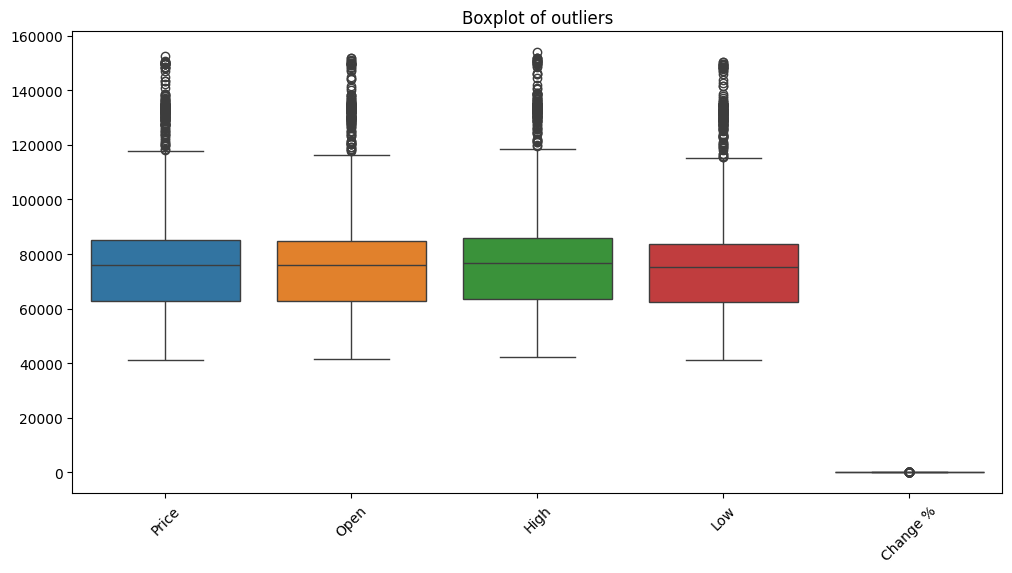

In [7]:
# Visualise outliers
plt.figure(figsize = (12,6))
sns.boxplot(data = df[num_col])
plt.xticks(rotation = 45)
plt.title("Boxplot of outliers")
plt.show()

Since the outliers are not due to errors but a true reflection of market changes, they should be kept in place instead of being removed or modified.

## C. Stationarity

In [8]:
from statsmodels.tsa.api import adfuller

# Perform ADF test on "Closing Price"
results = adfuller(df["Price"])

# Print results
print(f"ADF Test Results")
print(f"ADF Statistics: {results[0]}")
print(f"P-values: {results[1]}")
print(f"Critical values:")
for key, value in results[4].items():
    print(f"{key}: {value}")

# Interpretation:
print("Reject H0. The time series is Stationary") if results[1] < 0.05 else print("Cannot reject H0 (Non-stationary)")

ADF Test Results
ADF Statistics: -2.2470242774842326
P-values: 0.18962292593404895
Critical values:
1%: -3.436972562223603
5%: -2.864463856182476
10%: -2.5683268054280175
Cannot reject H0 (Non-stationary)


In [9]:
# Reverse dataset (from decending to ascending order) to prepare for handling non-stationary issue
df = df.sort_values(by = "Date", ascending = True)

# Handle non-stationary time series, using "differencing"
df["Price_diff"] = df["Price"].diff()

# Drop NaN values after differencing (the first row)
df.dropna(inplace = True)

In [10]:
# Re-run ADF test
result = adfuller(df["Price_diff"].dropna())

print(f"ADF Statistics: {result[0]}")
print(f"P-value: {result[1]}")

ADF Statistics: -10.888862365042781
P-value: 1.2398068636557496e-19


In [11]:
# The data is now stationary (free of trend)
# Display the dataset
print(df.tail())

        Date     Price      Open      High       Low   Vol.  Change %  \
4 2024-12-25  150800.0  150600.0  151200.0  150400.0  2.51M    0.0027   
3 2024-12-26  149800.0  151000.0  151400.0  149100.0  2.23M   -0.0066   
2 2024-12-27  149600.0  149500.0  149900.0  148700.0  2.56M   -0.0013   
1 2024-12-30  150500.0  149400.0  150800.0  148500.0  1.98M    0.0060   
0 2024-12-31  152500.0  150700.0  153900.0  150300.0  3.60M    0.0133   

   Price_diff  
4       400.0  
3     -1000.0  
2      -200.0  
1       900.0  
0      2000.0  


# 2. Feature Engineering

## A. Technical Indicators

### Feature 1 - Moving Average

In [12]:
# Moving average
# Smooth moving average
# Compute moving average, including 5-day, 20-day, and 50-day periods
df["SMA_5"] = df["Price"].rolling(window = 5).mean()
df["SMA_20"] = df["Price"].rolling(window = 20).mean()
df["SMA_50"] = df["Price"].rolling(window = 50).mean()

df.dropna(inplace = True)

print(df.tail())

        Date     Price      Open      High       Low   Vol.  Change %  \
4 2024-12-25  150800.0  150600.0  151200.0  150400.0  2.51M    0.0027   
3 2024-12-26  149800.0  151000.0  151400.0  149100.0  2.23M   -0.0066   
2 2024-12-27  149600.0  149500.0  149900.0  148700.0  2.56M   -0.0013   
1 2024-12-30  150500.0  149400.0  150800.0  148500.0  1.98M    0.0060   
0 2024-12-31  152500.0  150700.0  153900.0  150300.0  3.60M    0.0133   

   Price_diff     SMA_5    SMA_20     SMA_50  
4       400.0  149720.0  147616.7  139421.78  
3     -1000.0  150060.0  148185.0  139696.76  
2      -200.0  150080.0  148500.0  139967.74  
1       900.0  150220.0  148915.0  140286.52  
0      2000.0  150640.0  149290.0  140692.96  


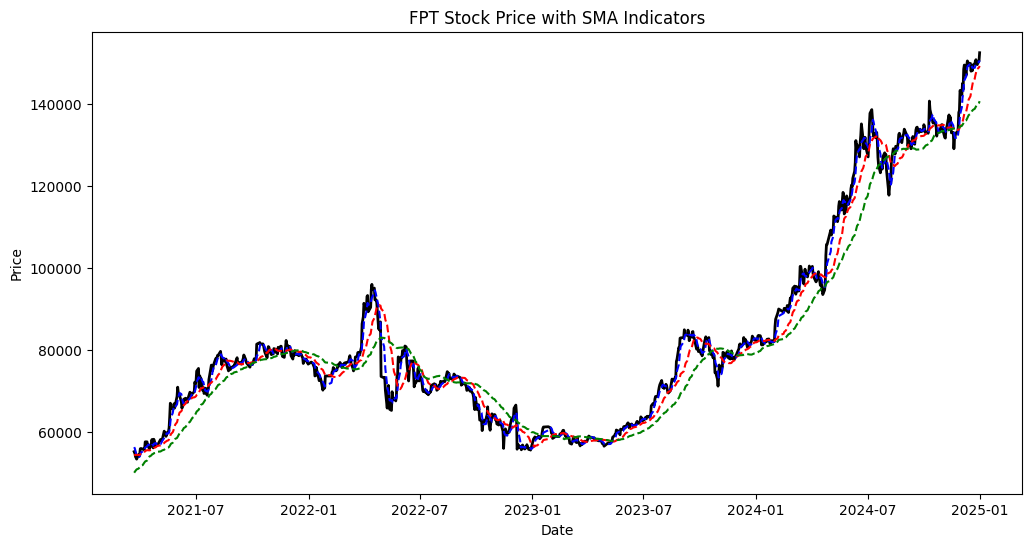

In [13]:
# Visualise data to validate trends across different window moving averages
plt.figure(figsize = (12,6))

plt.plot(df["Date"], df["Price"], label = "Price", color = "black", linewidth = 2)
plt.plot(df["Date"], df["SMA_5"], label = "SMA_5", linestyle = "dashed", color = "blue")
plt.plot(df["Date"], df["SMA_20"], label = "SMA_20", linestyle = "dashed", color = "red")
plt.plot(df["Date"], df["SMA_50"], label = "SMA_50", linestyle = "dashed", color = "green")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("FPT Stock Price with SMA Indicators")
plt.show()

### Feature 2 - Relative Strength Index (RSI)

Constraints: Range: 0 - 100
* Above 70: overbought --> Price may drop soon
* Below 30: oversold --> Price may rise soon

* Gain = Price Today - Price Yesterday (only when price increases)
* Loss = Price Yesterday - Price Today (only when price decreases)
* Calculate Average Gain & Average Loss over N days
* Relative Strength = Average gain / Average Loss
* RSI = 100 - (100/(1+RS))

In [14]:
# Compute Daily Gains & Losses
df["Gains"] = np.where(df["Price_diff"] > 0, df["Price_diff"], 0)
df["Losses"] = np.where(df["Price_diff"] < 0, -df["Price_diff"], 0)

In [15]:
df.head(2)

,Date,Price,Open,High,Low,Vol.,Change %,Price_diff,SMA_5,SMA_20,SMA_50,Gains,Losses
947,2021-03-22,55284.6,55846.6,55916.9,55003.6,2.88M,-0.0138,-772.8,56380.48,54325.76,50146.740,0.0,772.8
946,2021-03-23,55354.9,55144.1,56197.8,55003.6,3.04M,0.0013,70.3,56071.40,54441.67,50372.936,70.3,0.0


In [16]:
# Calculate average gain and loss over 14-day period
window = 14

df["Avg_Gain"] = df["Gains"].rolling(window = window, min_periods = 1).mean()
df["Avg_Loss"] = df["Losses"].rolling(window = window, min_periods = 1).mean()

In [17]:
# Calculate RS and RSI
df["RS"] = df["Avg_Gain"] / df["Avg_Loss"]
df["RSI"] = 100 - (100/(1+df["RS"] + 1e-10))

In [18]:
print(df[["Avg_Gain", "Avg_Loss"]].describe())
print(df[df["Avg_Loss"] == 0])

          Avg_Gain     Avg_Loss
count   948.000000   948.000000
mean    535.461411   439.354947
std     349.522457   342.292471
min       0.000000    30.357143
25%     274.536688   209.321429
50%     447.035714   343.428571
75%     704.857143   577.357143
max    1686.214286  2509.357143
Empty DataFrame
Columns: [Date, Price, Open, High, Low, Vol., Change %, Price_diff, SMA_5, SMA_20, SMA_50, Gains, Losses, Avg_Gain, Avg_Loss, RS, RSI]
Index: []


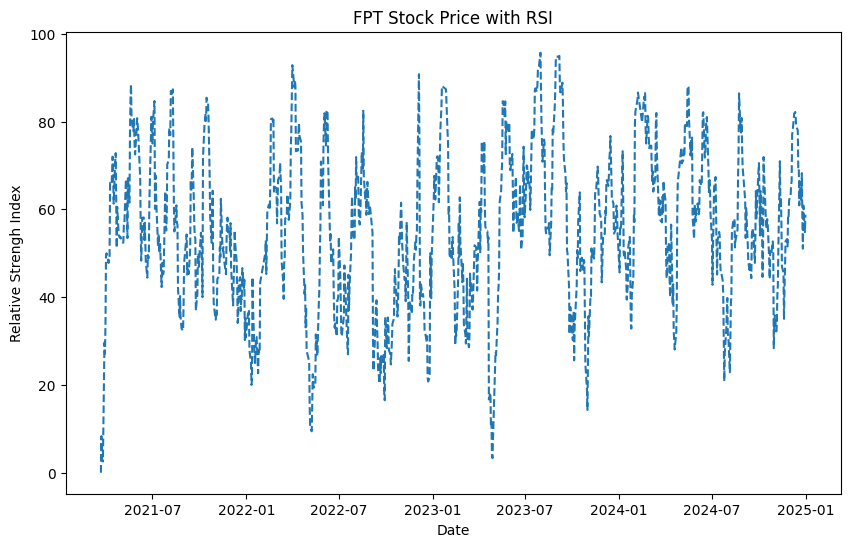

In [19]:
# Visualise RSI
plt.figure(figsize = (10,6))
plt.plot(df["Date"], df["RSI"], label = "RSI", linestyle = "dashed")

plt.xlabel("Date")
plt.ylabel("Relative Strengh Index")
plt.title("FPT Stock Price with RSI")

plt.show()

### Feature 3: Moving Average Convergence Divergence (MACD)

In [20]:
# First, we need to calculate Exponential moving average, starting with 12-day and 26-day periods
df["EMA_12"] = df["Price"].ewm(span = 12, adjust = False).mean()
df["EMA_26"] = df["Price"].ewm(span = 26, adjust = False).mean()

In [21]:
# Next, we will compute MACD, which is the difference between the 12-day EMA and 26-day EMA
df["MACD"] = df["EMA_12"] - df["EMA_26"]

In [22]:
# We will now compute the Signal Line (9-day EMA of MACD). This allows smoothing out short-term fluctuations
df["Signal_Line"] = df["MACD"].ewm(span = 9, adjust = False).mean()

In [23]:
# Compute the MACD Histogram
df["MACD_histogram"] = df["MACD"] - df["Signal_Line"]

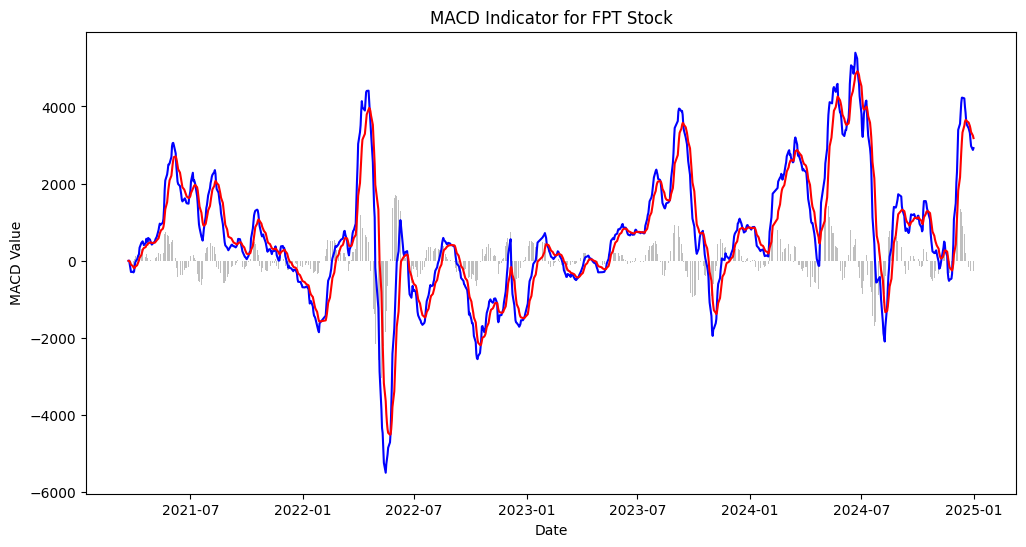

In [24]:
# Plot MACD to visualise trends
plt.figure(figsize = (12, 6))
plt.plot(df["Date"], df["MACD"], label = "MACD", color = "blue")
plt.plot(df["Date"], df["Signal_Line"], label = "Signal Line", color = "red")
plt.bar(df["Date"], df["MACD_histogram"], label = "MACD Histogram", color = "gray", alpha = 0.5)

plt.xlabel("Date")
plt.ylabel("MACD Value")
plt.title("MACD Indicator for FPT Stock")
plt.show()

### Feature 4: Bollinger Bands

In [25]:
# Compute the middle band (20-day SMA)
df["Middle_Band"] = df["Price"].rolling(window = 20).mean()

# Compute the Upper and Lower Bands
df["STD"] = df["Price"].rolling(window=20).std() # Standard deviation over 20 days
df["Upper_Band"] = df["Middle_Band"] + (2*df["STD"])
df["Lower_Band"] = df["Middle_Band"] - (2*df["STD"])

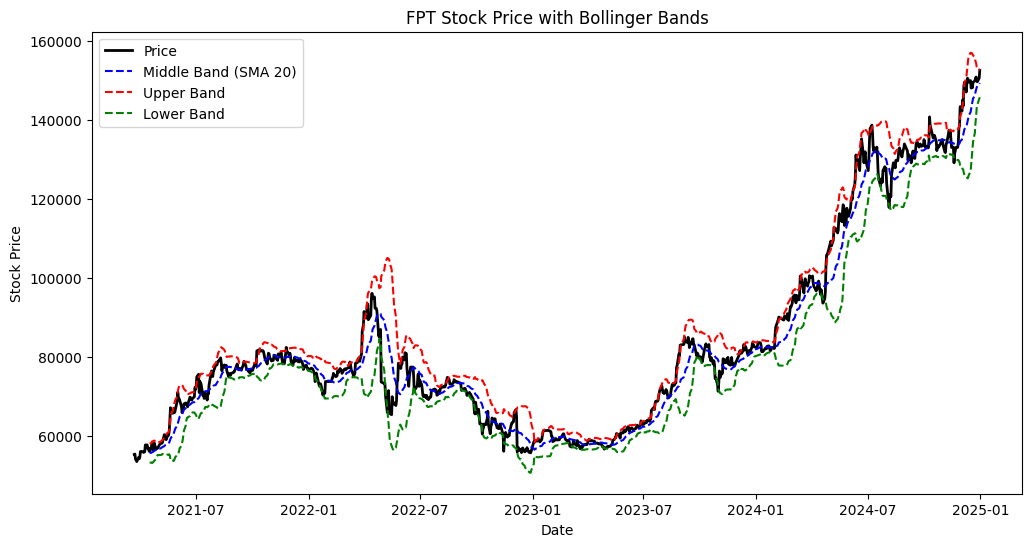

In [26]:
# Visualise the Bands
plt.figure(figsize = (12, 6))

plt.plot(df["Date"], df["Price"], label = "Price", color = "black", linewidth = 2)

plt.plot(df["Date"], df["Middle_Band"], label = "Middle Band (SMA 20)", color = "blue", linestyle = "dashed")
plt.plot(df["Date"], df["Upper_Band"], label = "Upper Band", color = "red", linestyle = "dashed")
plt.plot(df["Date"], df["Lower_Band"] , label = "Lower Band", color = "green", linestyle = 'dashed')

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title('FPT Stock Price with Bollinger Bands')
plt.legend()
plt.show()

In [27]:
print(df[["Price", "SMA_5", "SMA_20", "SMA_50", "RSI", "MACD", "Signal_Line", "MACD_histogram", "Upper_Band", "Lower_Band"]].tail(10))

      Price     SMA_5     SMA_20     SMA_50        RSI         MACD  \
9  148700.0  149260.0  143697.80  138197.84  69.542374  3840.219257   
8  148100.0  148840.0  144498.90  138345.48  60.909091  3626.087594   
7  149500.0  148840.0  145325.30  138562.82  66.367713  3528.678597   
6  149800.0  148820.0  146166.70  138825.90  62.121212  3436.079770   
5  150400.0  149300.0  146973.55  139112.88  68.253968  3372.236475   
4  150800.0  149720.0  147616.70  139421.78  58.041958  3315.695586   
3  149800.0  150060.0  148185.00  139696.76  51.048951  3153.839384   
2  149600.0  150080.0  148500.00  139967.74  60.833333  2975.133364   
1  150500.0  150220.0  148915.00  140286.52  54.807692  2873.011743   
0  152500.0  150640.0  149290.00  140692.96  58.771930  2919.805211   

   Signal_Line  MACD_histogram     Upper_Band     Lower_Band  
9  3648.727100      191.492157  156874.019801  130521.580199  
8  3644.199199      -18.111605  156605.314462  132392.485538  
7  3621.095078      -92.41648

In [28]:
df.isnull().sum()

Date               0
Price              0
Open               0
High               0
Low                0
Vol.               0
Change %           0
Price_diff         0
SMA_5              0
SMA_20             0
SMA_50             0
Gains              0
Losses             0
Avg_Gain           0
Avg_Loss           0
RS                 0
RSI                0
EMA_12             0
EMA_26             0
MACD               0
Signal_Line        0
MACD_histogram     0
Middle_Band       19
STD               19
Upper_Band        19
Lower_Band        19
dtype: int64

In [29]:
df.dropna(inplace = True)

## **3. Model Training**

## **XGBoost**

In [30]:
# Select relevant features for AI modeling
features = ["Date", "Price", "SMA_5", "SMA_20", "SMA_50", "RSI", "MACD", 
            "Signal_Line", "MACD_histogram", "Upper_Band", "Lower_Band"]
df = df[features]

In [31]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Ensure data is sorted by date
df = df.sort_values(by = "Date")

# Define features (X) and target (y)
X = df.drop(columns = ["Price", "Date"])
y = df["Price"]
dates = df["Date"]

# Define dataset size and initial training window (80% training)
n = len(df)
window_size = int(n * 0.8) # Start with 80% training

In [32]:
# Store predictions and actual values
predictions = []
actuals = []
predicted_dates =[]

# Initialise XGBoost Model
model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)

In [33]:
# Walk-forward validation loop
for i in range(window_size, n):
    X_train, y_train = X.iloc[:i], y.iloc[:i] # Train on past data
    X_test, y_test = X.iloc[i:i+1], y.iloc[i:i+1] # Test on next day only

    # Train model
    model.fit(X_train, y_train)

    # Predict next day's price
    y_pred = model.predict(X_test)
    predictions.append(y_pred[0])
    actuals.append(y_test.values[0])
    predicted_dates.append(dates.iloc[i]) # Store corresponding test date

# Compute final MAE (Mean Absolute Error)
mae = mean_absolute_error(actuals, predictions)
print(f"MAE: {mae}")

MAE: 1614.586147513441


In [34]:
# Convert results to Dataframe
results = pd.DataFrame({"Date": predicted_dates, "Actual_Price": actuals, "Predicted_Price": predictions})

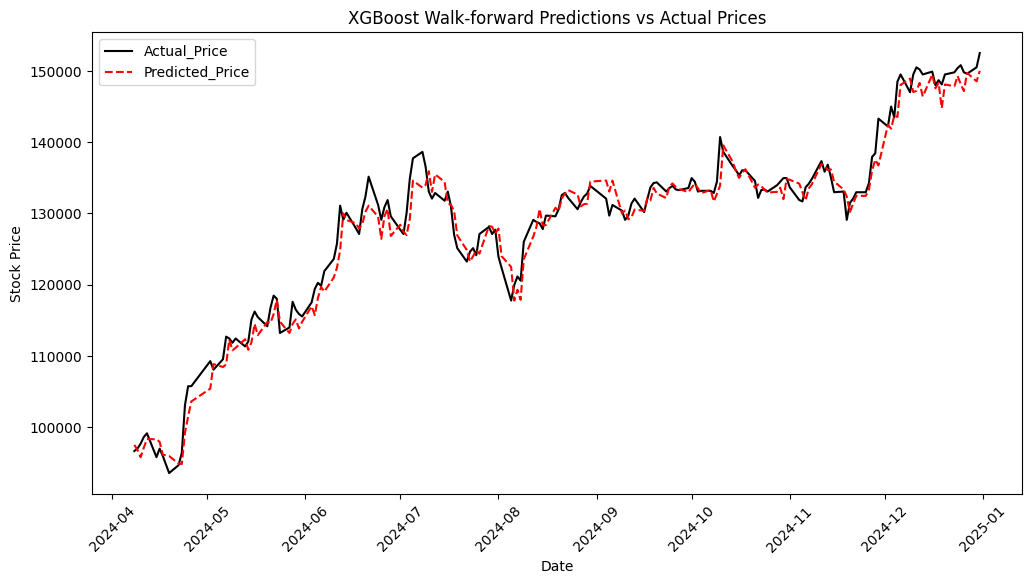

In [35]:
# Plot predictions vs actual prices
plt.figure(figsize = (12, 6))
plt.plot(results["Date"], results["Actual_Price"], label = "Actual_Price", color = "black")
plt.plot(results["Date"], results["Predicted_Price"], label = "Predicted_Price", color = "red", linestyle = "dashed")

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("XGBoost Walk-forward Predictions vs Actual Prices")
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [36]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "n_estimators": [100, 300, 500], # More trees improve learning
    "learning_rate": [0.01, 0.05, 0.1], # Lower is more accurate but slower
    "max_depth": [3, 6, 9], # Deeper trees capture more patterns, but need to be careful about overfitting
    "subsample": [0.8, 1.0], # Using a fraction of data prevents overfitting
    "colsample_bytree": [0.8, 1.0], # Controls feature selection per tree
}

xgb = XGBRegressor(random_state = 42)

In [37]:
# Grid Search with Cross-validation
grid_search = GridSearchCV(
    estimator = xgb, param_grid = param_grid,
    scoring = "neg_mean_absolute_error", cv = 3, verbose = 1, n_jobs = -1
)

# Train GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}


In [38]:
# Train XGBoost with best parameters
best_xgb = XGBRegressor(**grid_search.best_params_, random_state = 42)
best_xgb.fit(X_train, y_train)

# Predict using optmised model
y_pred_optimised = best_xgb.predict(X_test)

# Evaluate new MAE
mae_optimised = mean_absolute_error(y_test, y_pred_optimised)
print(f"Optimised XGBoost MAE: {mae_optimised}")

Optimised XGBoost MAE: 2403.546875


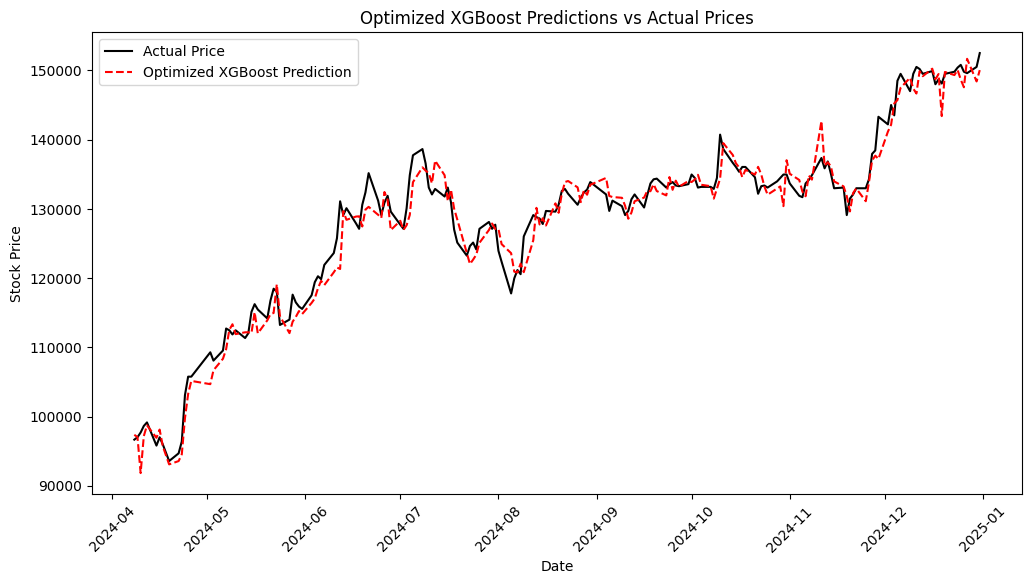

Optimized XGBoost MAE: 1709.3380376344087


In [39]:
# Ensure data is sorted by Date
df = df.sort_values(by="Date")

# Define features (X) and target (y)
X = df.drop(columns=["Price", "Date"])  # Drop target and Date
y = df["Price"]  # Target variable (Stock Price)
dates = df["Date"]  # Store dates for plotting

# Define dataset size and initial training window (80%)
n = len(df)
window_size = int(n * 0.8)  # 80% training size

# Store predictions, actual values, and test dates
predictions = []
actuals = []
test_dates = []  # Store correct dates for plotting

# Initialize Optimized XGBoost Model (Hyperparameters can be further tuned)
optimized_model = XGBRegressor(n_estimators=500, learning_rate=0.5, max_depth=3, subsample=0.8, colsample_bytree=1.0, random_state=42)

# Walk-forward validation loop
for i in range(window_size, n):
    # Train on past data
    X_train, y_train = X.iloc[:i], y.iloc[:i]  
    X_test, y_test = X.iloc[i:i+1], y.iloc[i:i+1]  # Test on next day only

    # Train Optimized XGBoost model
    optimized_model.fit(X_train, y_train)

    # Predict next day's price
    y_pred = optimized_model.predict(X_test)
    predictions.append(y_pred[0])
    actuals.append(y_test.values[0])
    test_dates.append(dates.iloc[i])  # Store correct test date

# Convert results to DataFrame
results_df = pd.DataFrame({"Date": test_dates, "Actual_Price": actuals, "Predicted_Price": predictions})

# Plot Optimized XGBoost Predictions vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(results_df["Date"], results_df["Actual_Price"], label="Actual Price", color="black")
plt.plot(results_df["Date"], results_df["Predicted_Price"], label="Optimized XGBoost Prediction", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Optimized XGBoost Predictions vs Actual Prices")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Compute final MAE
mae_optimized = mean_absolute_error(actuals, predictions)
print(f"Optimized XGBoost MAE: {mae_optimized}")

In [40]:
# Corrected computation:
std_actual = np.std(actuals)
print(f"Standard Deviation of Actual Prices: {std_actual:.2f} VND")

std_predicted = np.std(predictions)
print(f"Standard Deviation of Predicted Prices from XGBoost Model: {std_predicted:.2f} VND")

Standard Deviation of Actual Prices: 12836.71 VND
Standard Deviation of Predicted Prices from XGBoost Model: 13050.09 VND


<Axes: >

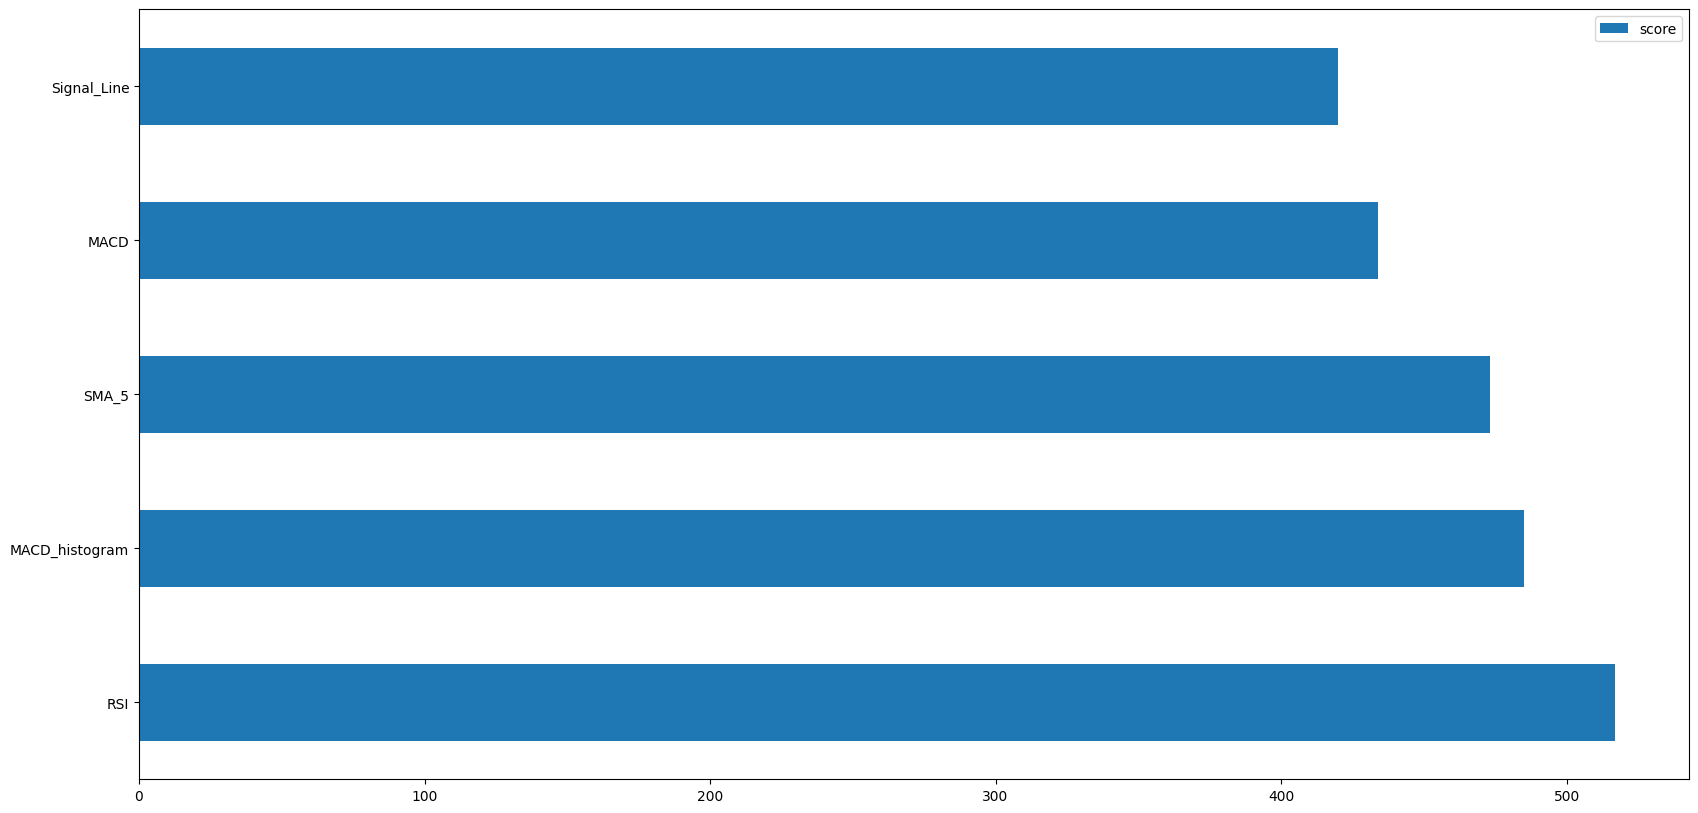

In [41]:
# Get feature importance
feature_important = optimized_model.get_booster().get_score(importance_type = "weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data = values, index = keys, columns = ["score"]).sort_values(by = "score", ascending = False)
data.nlargest(5, columns = "score").plot(kind = "barh", figsize = (20,10))

In [42]:
print("Features Used During Training:", X.columns.tolist())  # Check feature names

Features Used During Training: ['SMA_5', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'MACD_histogram', 'Upper_Band', 'Lower_Band']


In [43]:
import joblib

# Save trained XGBoost model
joblib.dump(optimized_model, "xgboost_fpt_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [44]:
# Load trained model
optimized_model = joblib.load("xgboost_fpt_model.pkl")
print("Model loaded successfully!")

Model loaded successfully!


In [45]:
import yfinance as yf
import joblib
import pandas as pd

# Load trained XGBoost model
xgb_model = joblib.load("xgboost_fpt_model.pkl")

# Fetch real-time stock data (ensure enough history for indicators)
stock_symbol = "FPT.VN"
stock_data = yf.download(stock_symbol, period="30d", interval="1h")  # Fetch 30 days of hourly data

# Compute SMA (Simple Moving Average)
stock_data["SMA_5"] = stock_data["Close"].rolling(window=5).mean()
stock_data["SMA_20"] = stock_data["Close"].rolling(window=20).mean()
stock_data["SMA_50"] = stock_data["Close"].rolling(window=50).mean()

# Compute RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_data["RSI"] = calculate_rsi(stock_data["Close"], 14)

# Compute MACD (Moving Average Convergence Divergence)
stock_data["EMA_12"] = stock_data["Close"].ewm(span=12, adjust=False).mean()
stock_data["EMA_26"] = stock_data["Close"].ewm(span=26, adjust=False).mean()
stock_data["MACD"] = stock_data["EMA_12"] - stock_data["EMA_26"]
stock_data["Signal_Line"] = stock_data["MACD"].ewm(span=9, adjust=False).mean()
stock_data["MACD_histogram"] = stock_data["MACD"] - stock_data["Signal_Line"]

# Compute Bollinger Bands
stock_data["Middle_Band"] = stock_data["Close"].rolling(window=20).mean()
stock_data["Std_Dev"] = stock_data["Close"].rolling(window=20).std()
stock_data["Upper_Band"] = stock_data["Middle_Band"] + (2 * stock_data["Std_Dev"])
stock_data["Lower_Band"] = stock_data["Middle_Band"] - (2 * stock_data["Std_Dev"])

# Forward-fill missing values
stock_data.fillna(method="ffill", inplace=True)

# Ensure all required features are included
required_features = ['SMA_5', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'MACD_histogram', 'Upper_Band', 'Lower_Band']

# Select latest data point
latest_data = stock_data.iloc[-1][required_features]
print("Latest Processed Data:", latest_data)

# Ensure data format matches training features
latest_data = latest_data.values.reshape(1, -1)

# Predict stock price
predicted_price = xgb_model.predict(latest_data)
print(f"Predicted Stock Price for FPT: {predicted_price[0]} VND")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Latest Processed Data: Price           Ticker
SMA_5                     138180.000000
SMA_20                    140205.000000
SMA_50                    140192.000000
RSI                           12.000000
MACD                        -646.237009
Signal_Line                 -267.713344
MACD_histogram              -378.523666
Upper_Band                143202.174108
Lower_Band                137207.825892
Name: 2025-03-11 06:00:00+00:00, dtype: float64
Predicted Stock Price for FPT: 138550.84375 VND


In [46]:
# Reset column names to remove Multi-Index
stock_data.columns = stock_data.columns.droplevel(1)  # Drops the second level ('FPT.VN')

# Print available columns after renaming
print("Updated Columns in stock_data:", stock_data.columns.tolist())


Updated Columns in stock_data: ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_5', 'SMA_20', 'SMA_50', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'MACD_histogram', 'Middle_Band', 'Std_Dev', 'Upper_Band', 'Lower_Band']


In [47]:
import yfinance as yf
import joblib
import pandas as pd

# Load trained XGBoost model
xgb_model = joblib.load("xgboost_fpt_model.pkl")

# Fetch real-time stock data (ensure enough history for indicators)
stock_symbol = "FPT.VN"
stock_data = yf.download(stock_symbol, period="30d", interval="1h")

# Fix Multi-Index Column Issue
stock_data.columns = stock_data.columns.droplevel(1)  # Drop the second level ('FPT.VN')

# Compute SMA (Simple Moving Average)
stock_data["SMA_5"] = stock_data["Close"].rolling(window=5).mean()
stock_data["SMA_20"] = stock_data["Close"].rolling(window=20).mean()
stock_data["SMA_50"] = stock_data["Close"].rolling(window=50).mean()

# Compute RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_data["RSI"] = calculate_rsi(stock_data["Close"], 14)

# Compute MACD (Moving Average Convergence Divergence)
stock_data["EMA_12"] = stock_data["Close"].ewm(span=12, adjust=False).mean()
stock_data["EMA_26"] = stock_data["Close"].ewm(span=26, adjust=False).mean()
stock_data["MACD"] = stock_data["EMA_12"] - stock_data["EMA_26"]
stock_data["Signal_Line"] = stock_data["MACD"].ewm(span=9, adjust=False).mean()
stock_data["MACD_histogram"] = stock_data["MACD"] - stock_data["Signal_Line"]

# Compute Bollinger Bands
stock_data["Middle_Band"] = stock_data["Close"].rolling(window=20).mean()
stock_data["Std_Dev"] = stock_data["Close"].rolling(window=20).std()
stock_data["Upper_Band"] = stock_data["Middle_Band"] + (2 * stock_data["Std_Dev"])
stock_data["Lower_Band"] = stock_data["Middle_Band"] - (2 * stock_data["Std_Dev"])

# Forward-fill missing values
stock_data.fillna(method="ffill", inplace=True)

# Verify all features exist
required_features = ["SMA_5", "SMA_20", "SMA_50", "RSI", "MACD", "Signal_Line", "MACD_histogram", "Upper_Band", "Lower_Band"]
missing_features = [feature for feature in required_features if feature not in stock_data.columns]

if missing_features:
    print(f"⚠️ Warning: The following features are missing: {missing_features}")

# Select latest data point
latest_data = stock_data.iloc[-1][required_features]
print("Latest Processed Data:", latest_data)

# Ensure data format matches training features
latest_data = latest_data.values.reshape(1, -1)

# Predict stock price
predicted_price = xgb_model.predict(latest_data)
print(f"Predicted Stock Price for FPT: {predicted_price[0]} VND")


[*********************100%***********************]  1 of 1 completed

Latest Processed Data: Price
SMA_5             138180.000000
SMA_20            140205.000000
SMA_50            140192.000000
RSI                   12.000000
MACD                -646.237009
Signal_Line         -267.713344
MACD_histogram      -378.523666
Upper_Band        143202.174108
Lower_Band        137207.825892
Name: 2025-03-11 06:00:00+00:00, dtype: float64
Predicted Stock Price for FPT: 138550.84375 VND


In [ ]:
import time
import yfinance as yf
import joblib
import pandas as pd

# Load trained model
xgb_model = joblib.load("xgboost_fpt_model.pkl")

while True:
    # Fetch real-time stock data
    stock_symbol = "FPT.VN"
    stock_data = yf.download(stock_symbol, period="30d", interval="1h")

    # Fix Multi-Index Column Issue
    stock_data.columns = stock_data.columns.droplevel(1)  # Drop the second level ('FPT.VN')

    # Compute SMA (Simple Moving Average)
    stock_data["SMA_5"] = stock_data["Close"].rolling(window=5).mean()
    stock_data["SMA_20"] = stock_data["Close"].rolling(window=20).mean()
    stock_data["SMA_50"] = stock_data["Close"].rolling(window=50).mean()

    # Compute RSI
    def calculate_rsi(data, window=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    stock_data["RSI"] = calculate_rsi(stock_data["Close"], 14)

    # Compute MACD
    stock_data["EMA_12"] = stock_data["Close"].ewm(span=12, adjust=False).mean()
    stock_data["EMA_26"] = stock_data["Close"].ewm(span=26, adjust=False).mean()
    stock_data["MACD"] = stock_data["EMA_12"] - stock_data["EMA_26"]
    stock_data["Signal_Line"] = stock_data["MACD"].ewm(span=9, adjust=False).mean()
    stock_data["MACD_histogram"] = stock_data["MACD"] - stock_data["Signal_Line"]

    # Compute Bollinger Bands
    stock_data["Middle_Band"] = stock_data["Close"].rolling(window=20).mean()
    stock_data["Std_Dev"] = stock_data["Close"].rolling(window=20).std()
    stock_data["Upper_Band"] = stock_data["Middle_Band"] + (2 * stock_data["Std_Dev"])
    stock_data["Lower_Band"] = stock_data["Middle_Band"] - (2 * stock_data["Std_Dev"])

    # Forward-fill missing values
    stock_data.fillna(method="ffill", inplace=True)

    # Ensure all required features are available
    required_features = ["SMA_5", "SMA_20", "SMA_50", "RSI", "MACD", 
                         "Signal_Line", "MACD_histogram", "Upper_Band", "Lower_Band"]
    
    latest_data = stock_data.iloc[-1][required_features].values.reshape(1, -1)

    # Predict stock price
    predicted_price = xgb_model.predict(latest_data)

    # Print and save prediction
    current_time = time.strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{current_time}] Predicted Stock Price for FPT: {predicted_price[0]:.2f} VND")

    # Append prediction to CSV file
    with open("real_time_predictions.csv", "a") as file:
        file.write(f"{current_time},{predicted_price[0]:.2f}\n")

    # Wait 1 hour before the next prediction
    time.sleep(3600)  # Sleep for 1 hour


[*********************100%***********************]  1 of 1 completed


[2025-03-11 13:44:14] Predicted Stock Price for FPT: 138550.84 VND


## **LSTM**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Ensure data is sorted by date
df = df.sort_values(by="Date")

# Select features for LSTM (Only numerical)
features = ["Price", "SMA_5", "SMA_20", "SMA_50", "RSI", "MACD", "Signal_Line"]
df = df[["Date"] + features]  # Keep Date for plotting

# Normalize data (LSTM works best with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[features])  # Scale only numerical data

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=features)
df_scaled["Date"] = df["Date"].values  # Keep Date column

In [ ]:
# Define time-step window size
window_size = 30  # Using past 30 days to predict the next

X, y = [], []

for i in range(len(df_scaled) - window_size):
    X.append(df_scaled.iloc[i:i+window_size][features].values)  # Past 30 days as input
    y.append(df_scaled.iloc[i+window_size]["Price"])  # Next day price as output

# Convert to NumPy arrays
X, y = np.array(X), np.array(y)

# Split data into training (80%) and testing (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shape of data (LSTM expects 3D input)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (719, 30, 7), y_train shape: (719,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Prevent overfitting
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)  # Output layer (predict stock price)
])

# Compile the model
model.compile(optimizer="adam", loss="mean_absolute_error")

# Train LSTM Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.1144 - val_loss: 0.1103
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0364 - val_loss: 0.1621
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0376 - val_loss: 0.0877
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0276 - val_loss: 0.1109
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0270 - val_loss: 0.0392
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0279 - val_loss: 0.1626
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0299 - val_loss: 0.0542
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0274 - val_loss: 0.0398
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0263 - val_loss: 0.0318
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0247 - val_loss: 0.0816
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0255 - val_loss: 0.0372
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

In [ ]:
# Predict stock prices
y_pred = model.predict(X_test)

# Rescale predictions back to original price range
y_pred_rescaled = scaler.inverse_transform(np.column_stack((y_pred, np.zeros((len(y_pred), len(features)-1)))))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.column_stack((y_test.reshape(-1,1), np.zeros((len(y_test), len(features)-1)))))[:, 0]

# Compute MAE
from sklearn.metrics import mean_absolute_error
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"LSTM Model MAE: {mae_lstm}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
LSTM Model MAE: 2123.1175519969684


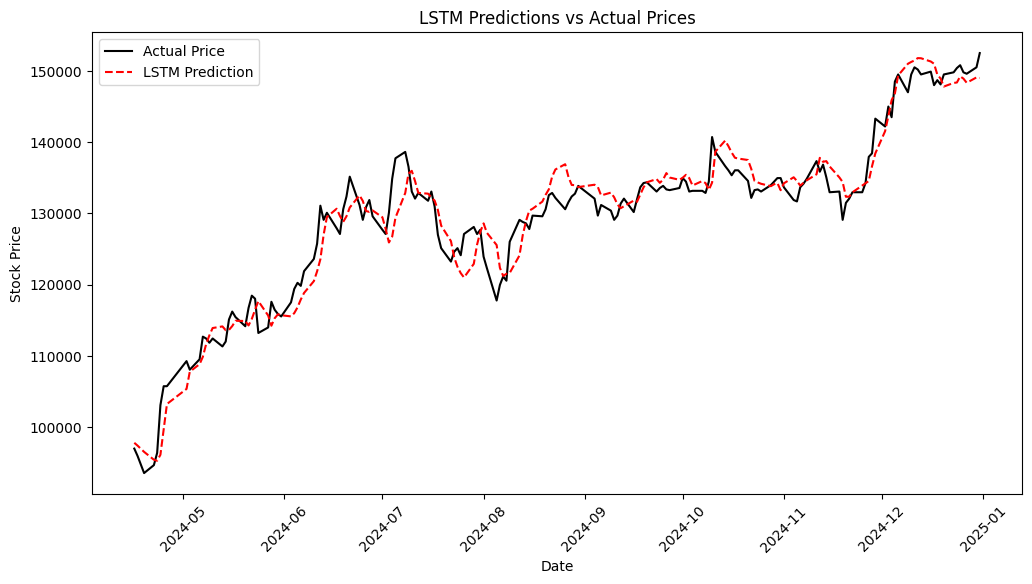

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df["Date"].iloc[-len(y_test_rescaled):], y_test_rescaled, label="Actual Price", color="black")
plt.plot(df["Date"].iloc[-len(y_test_rescaled):], y_pred_rescaled, label="LSTM Prediction", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM Predictions vs Actual Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
import numpy as np

# Compute historical standard deviation of actual prices
std_actual = np.std(y_test_rescaled)
print(f"Standard Deviation of Actual Prices: {std_actual:.2f} VND")

# Compute standard deviation of LSTM predicted prices
std_predicted = np.std(y_pred_rescaled)
print(f"Standard Deviation of Predicted Prices: {std_predicted:.2f} VND")

Standard Deviation of Actual Prices: 11691.51 VND
Standard Deviation of Predicted Prices: 12094.00 VND


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build LSTM Model
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile Model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_absolute_error")

# Train LSTM
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict with LSTM
lstm_pred = lstm_model.predict(X_test)

# Rescale LSTM predictions
lstm_pred_rescaled = scaler.inverse_transform(np.column_stack((lstm_pred, np.zeros((len(lstm_pred), len(features)-1)))))[:, 0]

# Compute LSTM MAE
mae_lstm = mean_absolute_error(y_test_rescaled, lstm_pred_rescaled)
print(f"LSTM MAE: {mae_lstm}")


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.1332 - val_loss: 0.0912
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0407 - val_loss: 0.1785
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0301 - val_loss: 0.0946
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0284 - val_loss: 0.0639
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0289 - val_loss: 0.1129
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0250 - val_loss: 0.0825
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0239 - val_loss: 0.0877
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0235 - val_loss: 0.0345
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0261 - val_loss: 0.0694
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0222 - val_loss: 0.0413
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0223 - val_loss: 0.0451
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0

# **Part 2: Sentiment Analysis**

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

## A. CafeF VN

In [ ]:
# Cafe.vn URL
url = "https://cafef.vn/du-lieu/tin-doanh-nghiep/fpt/event.chn"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"}

# Request the page
response = requests.get(url, headers = headers)
soup = BeautifulSoup(response.text, "html.parser")

# Find the correct news section  
news_section = soup.find("div", id = "divTopEvents") # Locate the div containing news

# Extract headlines, dates, and links
news_data = []
if news_section:
    items = news_section.find_all("li") # Each news item is inside <li>
    for item in items:
        title_tag = item.find("a") # Find the news title
        date_tag = item.find("span", class_ = "timeTitle") # Find the date

        if title_tag and date_tag:
            title = title_tag.text.strip()
            date = date_tag.text.strip()
            link = "https://cafef.vn" + title_tag["href"] # Full link

            news_data.append([date, title, link])

# Save to CSV
cafe = pd.DataFrame(news_data, columns = ["date", "headline", "link"])
cafe.to_csv("cafe.csv", index = False)

print ("Cafef.vn News Scarpped & Saved!")

Cafef.vn News Scarpped & Saved!


In [ ]:
cafe = pd.read_csv("cafe.csv")

cafe.head()

,date,headline,link
0,01/03/2025 00:05,"Sau Vĩnh Phúc, Khánh Hòa, Bà Rịa - Vũng Tàu, F...",https://cafef.vn/sau-vinh-phuc-khanh-hoa-ba-ri...
1,27/02/2025 11:32,"Thủ tướng triệu tập lãnh đạo T&T, Hoà Phát, Ge...",https://cafef.vn/thu-tuong-trieu-tap-lanh-dao-...
2,26/02/2025 09:32,FPT bắt tay cùng “ông lớn” Ấn Độ đào tạo kỹ sư...,https://cafef.vn/fpt-bat-tay-cung-ong-lon-an-d...
3,25/02/2025 15:31,FPT mở chương trình đào tạo nhân lực ngành ô t...,https://cafef.vn/fpt-mo-chuong-trinh-dao-tao-n...
4,25/02/2025 11:57,FPT 'chơi lớn' tại Nhật Bản: Mua thêm 1 tòa nh...,https://cafef.vn/fpt-choi-lon-tai-nhat-ban-mua...


## Vietstock VN

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

# Set up Selenium WebDriver
service = Service(ChromeDriverManager().install())
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Run in headless mode (no visible browser)
options.add_argument("--disable-blink-features=AutomationControlled")  # Avoid bot detection
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

In [ ]:
# Start WebDriver
driver = webdriver.Chrome(service=service, options=options)

# Open the Vietstock.vn news page
url = "https://finance.vietstock.vn/FPT/tin-tuc-su-kien.htm"
driver.get(url)

# Wait for JavaScript to load the content
time.sleep(5)  # Increase if necessary

# Extract news items
news_data = []
articles = driver.find_elements(By.CSS_SELECTOR, "a.text-link")  # Locate all news links

In [ ]:
for article in articles:
    spans = article.find_elements(By.TAG_NAME, "span")  # Find all <span> inside <a>

    if len(spans) >= 2:
        title = spans[0].text.strip()  # First span = Headline
        date = spans[1].text.strip().replace("(", "").replace(")", "")  # Second span = Date
    else:
        title = article.text.strip()
        date = "Unknown"

    link = article.get_attribute("href")
    if link is None:
        link = "N/A"
    elif not link.startswith("http"):
        link = "https://vietstock.vn" + link  # Ensure full URL

    news_data.append([date, title, link])

In [ ]:
# Close the browser
driver.quit()

# Save data to CSV
vietstock = pd.DataFrame(news_data, columns = ["date", "headline", "link"])
vietstock.to_csv("VietStock.csv", index = False)

print(vietstock.head())

         date                                           headline  \
0  04/03/2025  Phân tích kỹ thuật phiên chiều 04/03: Áp lực b...   
1  27/02/2025     FPT Telecom chi gần ngàn tỷ tạm ứng cổ tức 20%   
2  25/02/2025  Cuộc đua lợi nhuận VN30: Vinhomes giữ vững ngô...   
3  22/02/2025  VN-Index tiến sát 1,300 điểm, cổ phiếu nào đan...   
4  18/02/2025  Theo dấu dòng tiền cá mập 18/02: Tự doanh tiếp...   

                                                link  
0  https://vietstock.vn/2025/03/phan-tich-ky-thua...  
1  https://vietstock.vn/2025/02/fpt-telecom-chi-g...  
2  https://vietstock.vn/2025/02/cuoc-dua-loi-nhua...  
3  https://vietstock.vn/2025/02/vn-index-tien-sat...  
4  https://vietstock.vn/2025/02/theo-dau-dong-tie...  


## Vietnambiz.vn

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import html

# Define the base URL for VietnamBiz search results
base_url = "https://vietnambiz.vn/tim-kiem.htm?keywords=FPT&zoneid=0&page="

# Headers to mimic a browser visit
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

# Function to scrape VietnamBiz search results across multiple pages
def scrape_vietnambiz(pages=3):
    news_list = []

    for page in range(1, pages + 1):
        url = f"{base_url}{page}"
        print(f"Scraping page {page}: {url}")

        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.encoding = "utf-8"

            if response.status_code != 200:
                print(f"Failed to fetch page {page}: Status Code {response.status_code}")
                continue

            soup = BeautifulSoup(response.text, "html.parser")
            news_items = soup.find_all("div", class_="item")  # Main news container

            for item in news_items:
                try:
                    # Extract date
                    date_tag = item.find("div", class_="time")
                    date = date_tag.text.strip().split("|")[-1].strip() if date_tag else "No Date"

                    # Extract headline (from <a title="..."> attribute)
                    title_tag = item.find("a", title=True)
                    headline = html.unescape(title_tag["title"].strip() if title_tag else "No Headline")

                    # Extract link (ensure correct link format)
                    link_tag = item.find("a")
                    link = "https://vietnambiz.vn" + link_tag["href"] if link_tag and "href" in link_tag.attrs else "No Link"

                    news_list.append([date, headline, link])

                except Exception as e:
                    print(f"Error processing article: {e}")
                    continue

        except Exception as e:
            print(f"Error scraping page {page}: {e}")

        time.sleep(2)  # Pause to avoid being blocked

    return news_list

# Scrape VietnamBiz for 5 pages
vietnambiz_news = scrape_vietnambiz(pages=5)

# Save results to CSV
df_vbiz = pd.DataFrame(vietnambiz_news, columns=["Date", "Headline", "Link"])
df_vbiz.to_csv("vietnambiz.csv", index=False)

print("VietnamBiz news scraping complete! Data saved to 'vietnambiz.csv'")


Scraping page 1: https://vietnambiz.vn/tim-kiem.htm?keywords=FPT&zoneid=0&page=1
Scraping page 2: https://vietnambiz.vn/tim-kiem.htm?keywords=FPT&zoneid=0&page=2
Scraping page 3: https://vietnambiz.vn/tim-kiem.htm?keywords=FPT&zoneid=0&page=3
Scraping page 4: https://vietnambiz.vn/tim-kiem.htm?keywords=FPT&zoneid=0&page=4
Scraping page 5: https://vietnambiz.vn/tim-kiem.htm?keywords=FPT&zoneid=0&page=5
VietnamBiz news scraping complete! Data saved to 'vietnambiz.csv'


In [ ]:
print(df_vbiz)

          Date                                           Headline  \
0   06/03/2025  Nhóm Dragon Capital bán ròng gần 3 triệu cổ ph...   
1   04/03/2025  FPT muốn làm khu đô thị công nghệ 9.300 tỷ ở N...   
2   02/03/2025  NĐT cá nhân mua ròng hơn 9.000 tỷ đồng trong t...   
3   27/02/2025  FPT Telecom sắp chi gần nghìn tỷ đồng tạm ứng ...   
4   26/02/2025            FPT Retail muốn thu kỷ lục gần 2 tỷ USD   
..         ...                                                ...   
85  06/03/2025  Cổ phiếu BCG, TCD cùng thoát sàn, thanh khoản ...   
86  06/03/2025  Giá vàng nhẫn có thể đạt mốc 100 triệu đồng/lư...   
87  06/03/2025  VDSC: Xu hướng thị trường vẫn tích cực, VN-Ind...   
88  06/03/2025  Khối ngoại lần đầu mua ròng sau 10 phiên, tâm ...   
89  06/03/2025  Kẹo rau củ Quang Linh Vlogs, Thuỳ Tiên quảng c...   

                                                 Link  
0   https://vietnambiz.vn/nhom-dragon-capital-ban-...  
1   https://vietnambiz.vn/fpt-muon-lam-khu-do-thi-...  
2  

In [ ]:
import pandas as pd

news = pd.concat([df_vbiz, vietstock, cafe], ignore_index = True)

## **Sentiment Analysis**

### Preprocessing the Headlines

In [ ]:
from underthesea import word_tokenize

# Tokenize Vietnamese text
def tokenize_vietnamese(text):
    return word_tokenize(text)

text = "FPT là một công ty công nghệ hàng đầu tại Việt Nam"
tokens = tokenize_vietnamese(text)
print(tokens)

['FPT', 'là', 'một', 'công ty', 'công nghệ', 'hàng đầu', 'tại', 'Việt Nam']


In [ ]:
# Function to tokenize Vietnamese text
def tokenize_vietnamese(text):
    return word_tokenize(text) if isinstance(text, str) else []

# Apply tokenization
news["Tokenized"] = news["Headline"].apply(tokenize_vietnamese)

# Verify column is created
print(news["Tokenized"].head())

0    [Nhóm, Dragon Capital, bán, ròng, gần, 3, triệ...
1    [FPT, muốn, làm, khu, đô thị, công nghệ, 9.300...
2    [NĐT, cá nhân, mua, ròng, hơn, 9.000, tỷ, đồng...
3    [FPT, Telecom, sắp, chi, gần, nghìn, tỷ, đồng,...
4    [FPT, Retail, muốn, thu, kỷ lục, gần, 2, tỷ, USD]
Name: Tokenized, dtype: object


In [ ]:
with open("vietnamese-stopwords.txt", "r", encoding = "utf-8") as f:
    vietnamese_stopwords = set(f.read().splitlines())

In [ ]:
# Removing Stopwords
# Function to remove Vietnamese stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in vietnamese_stopwords]

# Apply stopword removal
news["Filtered_Tokens"] = news["Tokenized"].apply(remove_stopwords)

# Show the cleaned results
news[["Tokenized", "Filtered_Tokens"]].head()

,Tokenized,Filtered_Tokens
0,"[Nhóm, Dragon Capital, bán, ròng, gần, 3, triệ...","[Nhóm, Dragon Capital, ròng, 3, triệu, cổ phiế..."
1,"[FPT, muốn, làm, khu, đô thị, công nghệ, 9.300...","[FPT, khu, đô thị, công nghệ, 9.300, tỷ, Nha T..."
2,"[NĐT, cá nhân, mua, ròng, hơn, 9.000, tỷ, đồng...","[NĐT, mua, ròng, 9.000, tỷ, đồng, 2, ,, tâm đi..."
3,"[FPT, Telecom, sắp, chi, gần, nghìn, tỷ, đồng,...","[FPT, Telecom, chi, nghìn, tỷ, đồng, tạm ứng, ..."
4,"[FPT, Retail, muốn, thu, kỷ lục, gần, 2, tỷ, USD]","[FPT, Retail, thu, kỷ lục, 2, tỷ, USD]"


## Sentiment Analysis Methods

### VADER

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download Vader Lexicon
nltk.download("vader_lexicon")

# Initialize Vader
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nghia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Function to apply Vader sentiment analysis
def get_vader_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores["compound"] >= 0.05:
        return "Positive"
    elif scores["compound"] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply Vader to filtered news headlines
news["Vader_sentiment"] = news["Filtered_Tokens"].apply(lambda x: get_vader_sentiment(" ".join(x)))

# Show results
print(news[["Headline", "Vader_sentiment"]].head())

                                            Headline Vader_sentiment
0  Nhóm Dragon Capital bán ròng gần 3 triệu cổ ph...         Neutral
1  FPT muốn làm khu đô thị công nghệ 9.300 tỷ ở N...         Neutral
2  NĐT cá nhân mua ròng hơn 9.000 tỷ đồng trong t...         Neutral
3  FPT Telecom sắp chi gần nghìn tỷ đồng tạm ứng ...         Neutral
4            FPT Retail muốn thu kỷ lục gần 2 tỷ USD         Neutral


In [ ]:
print(news["Vader_sentiment"].unique())

['Neutral' 'Positive']
